In [396]:
import networkx as nx
import numpy as np

P = {
    "ABCD": 200,
    "ABC": 200,
    "BCD": 50,
    "BC": 50,
    "C": 100,
    "AB": 200,
    "B": 100,
    "A": 50,
}

keys = list(P.keys())
values = list(P.values())

P = {k : v /sum(values) for k,v in P.items()}

G = nx.DiGraph()
G.add_nodes_from([(k, {"layer": len(k)}) for k in keys])
for key1 in keys:
    for key2 in keys:
        if (key2.startswith(key1) or key2.endswith(key1)) and (key1 != key2):  # key 1 = ABC, key 2 = ABCD
            G.add_edge(key2, key1, weight=np.random.uniform(0, 1))

for node in G.nodes():
    out_edges = G.out_edges(node, data=True)
    total_out = sum([data["weight"] for _,_,data in G.out_edges(node, data=True)])
    for key, target, data in out_edges:
        nx.set_edge_attributes(
            G, {(key, target): {"weight": .8*data["weight"] / total_out}}
        )

G.out_edges(data=True)

OutEdgeDataView([('ABCD', 'ABC', {'weight': 0.12225125526248266}), ('ABCD', 'BCD', {'weight': 0.16686862906305525}), ('ABCD', 'AB', {'weight': 0.3129191922069818}), ('ABCD', 'A', {'weight': 0.19796092346748023}), ('ABC', 'BC', {'weight': 0.026254076406054355}), ('ABC', 'C', {'weight': 0.3018641310880821}), ('ABC', 'AB', {'weight': 0.06390717709742867}), ('ABC', 'A', {'weight': 0.4079746154084349}), ('BCD', 'BC', {'weight': 0.13459072193190866}), ('BCD', 'B', {'weight': 0.6654092780680914}), ('BC', 'C', {'weight': 0.5897585910917538}), ('BC', 'B', {'weight': 0.21024140890824627}), ('AB', 'B', {'weight': 0.24879362148395492}), ('AB', 'A', {'weight': 0.5512063785160451})])

In [397]:
def generate_guess(G: nx.DiGraph, keys):
    """
    Outputs a tuple of the distribution for the longest node and a matrix
    """
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {}
    terminal_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]
    
    for node in terminal_nodes:  # one hot terminal nodes
        oh_node = create_one_hot(keys, node)
        p_generated[node] = oh_node

    out_edges = {
        source: [target for _, target in G.out_edges(source) if source != target]
        for source in G.nodes()
    }
    

    while len(p_generated.keys()) < len(keys):
        solvables = get_solvable(out_edges, p_generated)
        for solvable in solvables:
            p_generated[solvable] = np.zeros(len(keys))
            
            for source, target in G.out_edges(solvable):
                p_target = p_generated[target]
                w_source_target = G[source][target]["weight"]
                p_generated[source] += w_source_target * p_target

            w_source_target = 1-sum([data["weight"] for _,_,data in G.out_edges(source, data=True)])
            p_target = create_one_hot(keys, source)
            p_generated[source] += w_source_target * p_target

    guess = {keys[i] : p_generated[longest_key][i] for i in range(len(keys))}
    print(G.edges(data=True))
    return guess, pd.DataFrame(p_generated, index=keys)


import pandas as pd


def create_one_hot(keys, key):
    one_hot = np.zeros(len(keys))
    one_hot[keys.index(key)] = 1
    return one_hot


def get_solvable(out_edges, p_generated):
    solvable = []
    for source, targets in out_edges.items():
        if (
            set(targets).issubset(set((p_generated.keys())))
            and source not in p_generated.keys()
        ):
            solvable.append(source)
    return solvable

guess, df = generate_guess(G, keys)
df

[('ABCD', 'ABC', {'weight': 0.12225125526248266}), ('ABCD', 'BCD', {'weight': 0.16686862906305525}), ('ABCD', 'AB', {'weight': 0.3129191922069818}), ('ABCD', 'A', {'weight': 0.19796092346748023}), ('ABC', 'BC', {'weight': 0.026254076406054355}), ('ABC', 'C', {'weight': 0.3018641310880821}), ('ABC', 'AB', {'weight': 0.06390717709742867}), ('ABC', 'A', {'weight': 0.4079746154084349}), ('BCD', 'BC', {'weight': 0.13459072193190866}), ('BCD', 'B', {'weight': 0.6654092780680914}), ('BC', 'C', {'weight': 0.5897585910917538}), ('BC', 'B', {'weight': 0.21024140890824627}), ('AB', 'B', {'weight': 0.24879362148395492}), ('AB', 'A', {'weight': 0.5512063785160451})]


,C,B,A,BC,AB,ABC,BCD,ABCD
ABCD,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.200000
ABC,0.0,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.024450
BCD,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.200000,0.033374
BC,0.0,0.0,0.0,0.200000,0.000000,0.005251,0.026918,0.005134
C,1.0,0.0,0.0,0.589759,0.000000,0.317348,0.079376,0.052042
AB,0.0,0.0,0.0,0.000000,0.200000,0.012781,0.000000,0.064146
B,0.0,1.0,0.0,0.210241,0.248794,0.021419,0.693706,0.196229
A,0.0,0.0,1.0,0.000000,0.551206,0.443201,0.000000,0.424626


$ q - "observerade fördelningen" (n_i / n) $

$ p - "skattade fördelningen" $

$ D_{KL} = \sum q * (log(q) - log(p)) $

Ekvivalent med att minimera $ - \sum q * log(p) $


$dL / dp = - q / p $

$dp / dw = P ( $ arriving at source $ ) * P( $ target $ )$

$dL / dw = dL / dp * dp / dw = - q/p * P ( $ arriving at source $ ) * P( $ target $ )$

In [398]:
def compute_dp_dw(G, keys, df):
    longest_key = sorted(keys, key=len)[-1]
    prob_traversed = {key: 0 for key in keys}
    prob_traversed[longest_key] = 1
    
    for sequence, n in prob_traversed.items():
        out_edges = [
            (source, target, data)
            for source, target, data in G.out_edges(sequence, data=True)
        ]
        weights = np.array([weight["weight"] for _, _, weight in out_edges])
        edges_to = [edge_to for _, edge_to, _ in out_edges]
        for w, e in zip(weights, edges_to):
            prob_traversed[e] += w * n

    # TODO: spara matrisen
    dp_dw = {}
    
    for key in keys:
        out_edges = G.out_edges(key)
        for source, target in out_edges: # P(longest to source) * P(target)
            dp_dw[(source, target)] = prob_traversed[source] * (df[target].values - create_one_hot(keys, source))

    return dp_dw

from disassembly.estimate_weights import KL
def compute_dL_dp(q, p):
    """
    q = real
    p = guess
    """
    return - np.array(q) / np.array(p)

def compute_dL_dw(dL_dp, dp_dw): 
    dL_dw = {}
    for edge, val in dp_dw.items():
        dL_dw[edge] = np.sum(val*dL_dp)
    return dL_dw

dp_dw = compute_dp_dw(G, keys, df)
dL_dp = compute_dL_dp(list(P.values()), list(guess.values()))

dL_dw = compute_dL_dw(dL_dp, dp_dw)


In [399]:
def update_weights(G, grad, lr):
    
    for source in G.nodes():
        sum_old_weight = sum([data["weight"] for _, _, data in G.out_edges(source, data=True)])
        sum_diffs = 0
        diffs = {}
        for source, target in G.out_edges(source):
            old_weight = G[source][target]["weight"]
            new_weight = max(0, old_weight - lr*grad[(source, target)])
            diff = new_weight - old_weight
            sum_diffs += diff
            diffs[target] = diff
        k = 1
        while (sum_old_weight + k*sum_diffs) > 1:
            k = k/2
            
        for source, target in G.out_edges(source):
            nx.set_edge_attributes(
                    G, {(source, target): {"weight": G[source][target]["weight"] + diffs[target]*k}}
                )
        
    return G

In [400]:

lr = 0.1
generated = {}
kls = []
n_iterations = 1000
weights = np.zeros((len(G.edges()), n_iterations), dtype=float)


for i in range(n_iterations):
    guess, df = generate_guess(G, keys)
    generated[i] = guess
    kl = KL(P.values(), guess.values()) 
    dp_dw = compute_dp_dw(G, keys, df)
    dL_dp = compute_dL_dp(list(P.values()), list(guess.values()))
    grad = compute_dL_dw(dL_dp, dp_dw)
    weights[:, i] = [data["weight"] for _, _, data in G.edges(data=True)]
    G = update_weights(G, grad, lr)

    kls.append(kl)

[('ABCD', 'ABC', {'weight': 0.12225125526248266}), ('ABCD', 'BCD', {'weight': 0.16686862906305525}), ('ABCD', 'AB', {'weight': 0.3129191922069818}), ('ABCD', 'A', {'weight': 0.19796092346748023}), ('ABC', 'BC', {'weight': 0.026254076406054355}), ('ABC', 'C', {'weight': 0.3018641310880821}), ('ABC', 'AB', {'weight': 0.06390717709742867}), ('ABC', 'A', {'weight': 0.4079746154084349}), ('BCD', 'BC', {'weight': 0.13459072193190866}), ('BCD', 'B', {'weight': 0.6654092780680914}), ('BC', 'C', {'weight': 0.5897585910917538}), ('BC', 'B', {'weight': 0.21024140890824627}), ('AB', 'B', {'weight': 0.24879362148395492}), ('AB', 'A', {'weight': 0.5512063785160451})]
[('ABCD', 'ABC', {'weight': 0.26960559201205403}), ('ABCD', 'BCD', {'weight': 0.17401083171311937}), ('ABCD', 'AB', {'weight': 0.2934735427204514}), ('ABCD', 'A', {'weight': 0.10509257933084552}), ('ABC', 'BC', {'weight': 0.0}), ('ABC', 'C', {'weight': 0.22132844477160957}), ('ABC', 'AB', {'weight': 0.0}), ('ABC', 'A', {'weight': 0.3042

/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_45176/2581602691.py:32: RuntimeWarning: divide by zero encountered in divide
  return - np.array(q) / np.array(p)
/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_45176/2581602691.py:37: RuntimeWarning: invalid value encountered in multiply
  dL_dw[edge] = np.sum(val*dL_dp)


In [401]:
for edge in G.edges():
    grad_edge = grad[edge]
    weight = G[edge[0]][edge[1]]["weight"]

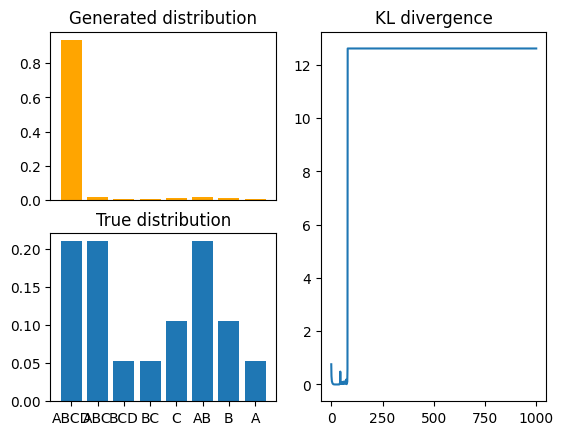

In [402]:
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 1), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 1

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
#axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [403]:
from disassembly.estimate_weights import estimate_weights


G, kls, generated, weights = estimate_weights(
    P=P,
    #meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=10,
    lr=2,
    n_iterations=500,
    N_T=200,
    alpha=0.05,
)


/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 100 / 500 | 2.91, mean: 2.91 | Increasing | nz: 22
Learning rate decreased to 1.0
 176 / 500 | 2.15, mean: 2.71 | Increasing | nz: 22
Learning rate decreased to 0.5
 252 / 500 | 0.96, mean: 1.39 | Increasing | nz: 21
Learning rate decreased to 0.25
 389 / 500 | 0.05, mean: 0.08 | Increasing | nz: 26
Learning rate decreased to 0.125
 499 / 500 | 0.02, mean: 0.03 | Plateau | nz: 27 27

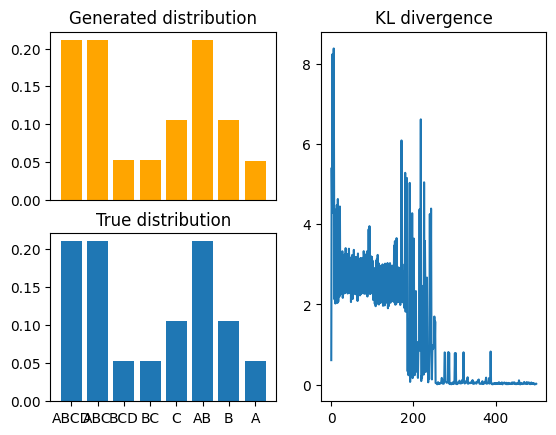

In [404]:
import matplotlib.pyplot as plt
fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 10), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 10

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
#axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [405]:

lr = 0.01
generated = {}
kls = []
n_iterations = 1000
weights = np.zeros((len(G.edges()), n_iterations), dtype=float)

for i in range(n_iterations):
    guess, df = generate_guess(G, keys)
    generated[i] = guess
    kl = KL(P.values(), guess.values()) 
    dp_dw = compute_dp_dw(G, keys, df)
    dL_dp = compute_dL_dp(list(P.values()), list(guess.values()))
    grad = compute_dL_dw(dL_dp, dp_dw)
    weights[:, i] = [data["weight"] for _, _, data in G.edges(data=True)]
    G = update_weights(G, grad, lr)

    kls.append(kl)


[('ABCD', 'ABCD', {'weight': 0.21537199504692578}), ('ABCD', 'ABC', {'weight': 0.2823040201011119}), ('ABCD', 'BCD', {'weight': 0.10221897348850352}), ('ABCD', 'BC', {'weight': 0.034680002399744815}), ('ABCD', 'C', {'weight': 0.031184585970329467}), ('ABCD', 'AB', {'weight': 0.2321187169752102}), ('ABCD', 'B', {'weight': 0.056481173393818015}), ('ABCD', 'A', {'weight': 0.045640532624356266}), ('ABC', 'ABC', {'weight': 0.6242382351663872}), ('ABC', 'BC', {'weight': 0.08970968809725552}), ('ABC', 'C', {'weight': 0.14181780266932012}), ('ABC', 'AB', {'weight': 0.05309200025934218}), ('ABC', 'B', {'weight': 0.07763794942019248}), ('ABC', 'A', {'weight': 0.013504324387502334}), ('BCD', 'BCD', {'weight': 0.5872246009692231}), ('BCD', 'BC', {'weight': 0.07581458219360483}), ('BCD', 'C', {'weight': 0.23196607224060853}), ('BCD', 'B', {'weight': 0.10499474459656363}), ('BC', 'BC', {'weight': 0.757647534389223}), ('BC', 'C', {'weight': 0.15599068094359905}), ('BC', 'B', {'weight': 0.086361784667

/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_45176/2581602691.py:32: RuntimeWarning: divide by zero encountered in divide
  return - np.array(q) / np.array(p)
/var/folders/64/ytcycnwx6w936vfxs5_7q3hm0000gn/T/ipykernel_45176/2581602691.py:37: RuntimeWarning: invalid value encountered in multiply
  dL_dw[edge] = np.sum(val*dL_dp)
